# Predicting Breast Cancer from Gene Expression Profiles (METABRIC)


In [ ]:
#importing required libraries
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#importing data preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV

#importing metrics for model evaluation
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

#imorting machine learing models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install catboost
!pip install imblearn
from catboost import CatBoostClassifier




#importing SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)


#importing warnings library. It would help to throw away warning caused

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df.head() # show first 5 rows of dataset

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,ush2a_mut,ryr2_mut,dnah5_mut,herc2_mut,pde4dip_mut,akap9_mut,tg_mut,birc6_mut,utrn_mut,tbx3_mut,col6a3_mut,arid1a_mut,lama2_mut,notch1_mut,cbfb_mut,ncor2_mut,col12a1_mut,col22a1_mut,pten_mut,akt1_mut,atr_mut,thada_mut,ncor1_mut,stab2_mut,myh9_mut,runx1_mut,nf1_mut,map2k4_mut,ros1_mut,lamb3_mut,arid1b_mut,erbb2_mut,sf3b1_mut,sha

In [ ]:
def dataset_statistics(df):
    num_rows = df.shape[0]
    num_columns = df.shape[1]
    column_names = df.columns.tolist()
    data_types = df.dtypes.value_counts()

    # Print the statistics
    print(f"Total rows: {num_rows}\n")
    print(f"Total columns: {num_columns}\n")
    # print(f"Column names: {column_names}\n")
    print("Any Duplicated Values: {}\n".format(df.duplicated().any())) # check duplicated values
    print("Data types:")
    print(data_types)

In [ ]:
# check the statistics of dataset
dataset_statistics(df)

Total rows: 1904

Total columns: 693

Any Duplicated Values: False

Data types:
float64    498
object     190
int64        5
dtype: int64


### Check Missing Values

In [ ]:
# patient_id number is a unique identifier
# and death_from_cancer is duplicate of overall_survival so we will drop it also
df.drop(['patient_id','death_from_cancer'], axis=1, inplace = True)

In [ ]:
# Replace Inf values with NaN if any
df = df.replace([np.inf, -np.inf], np.nan)

In [ ]:
missing = (df.isnull().mean()) > 0
missing_values_count = df.isnull().sum()[missing]
missing_values_percentage = ((df.isnull().sum() / len(df)) * 100)[missing]

missing_values_info = pd.DataFrame({
    'Missing Count': missing_values_count,
    'Missing Percentage': missing_values_percentage
})
missing_values_info = missing_values_info.sort_values(by='Missing Count', ascending=False)
missing_values_info

,Missing Count,Missing Percentage
tumor_stage,501,26.313025
3-gene_classifier_subtype,204,10.714286
primary_tumor_laterality,106,5.567227
neoplasm_histologic_grade,72,3.781513
cellularity,54,2.836134
mutation_count,45,2.363445
er_status_measured_by_ihc,30,1.575630
type_of_breast_surgery,22,1.155462
tumor_size,20,1.050420
cancer_type_detailed,15,0.787815


* The column "tumor_stage" has 501 missing values, accounting for approximately 26.31% of the total data.
Similarly, the "3-gene_classifier_subtype" column has 204 missing values, representing around 10.71% of the data.
* The feature "primary_tumor_laterality" has 106 missing values, constituting about 5.57% of the dataset.
* "neoplasm_histologic_grade," "cellularity," and "mutation_count" columns have 72, 54, and 45 missing values, respectively, making up 3.78%, 2.84%, and 2.36% of the dataset.
* Columns such as "er_status_measured_by_ihc," "type_of_breast_surgery," and "tumor_size" have smaller percentages of missing values, ranging from 1.58% to 1.05%.
* Some columns, like "cancer_type_detailed," "tumor_other_histologic_subtype," and "oncotree_code," have 15 missing values each, accounting for approximately 0.79% each.
* Finally, the "death_from_cancer" column has only one missing value, which is negligible at 0.05%.
It's important to address these missing values appropriately in the data preprocessing stage to ensure the accuracy and reliability of our analyses and model predictions.

<Axes: >

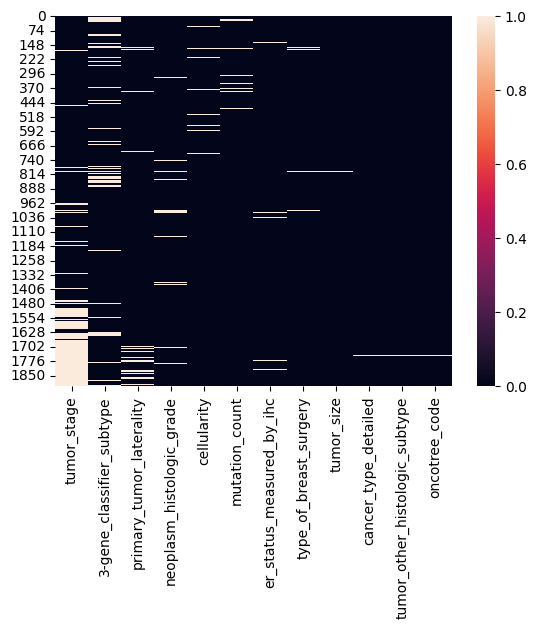

In [ ]:
# visualization of nullity of the dataset
sns.heatmap(df[missing_values_info.index.tolist()].isnull())

### Target Distribution

In [ ]:
df_copy = df.copy()
df_copy['overall_survival'] = df_copy['overall_survival'].map({0:'Died', 1:'Survived'})

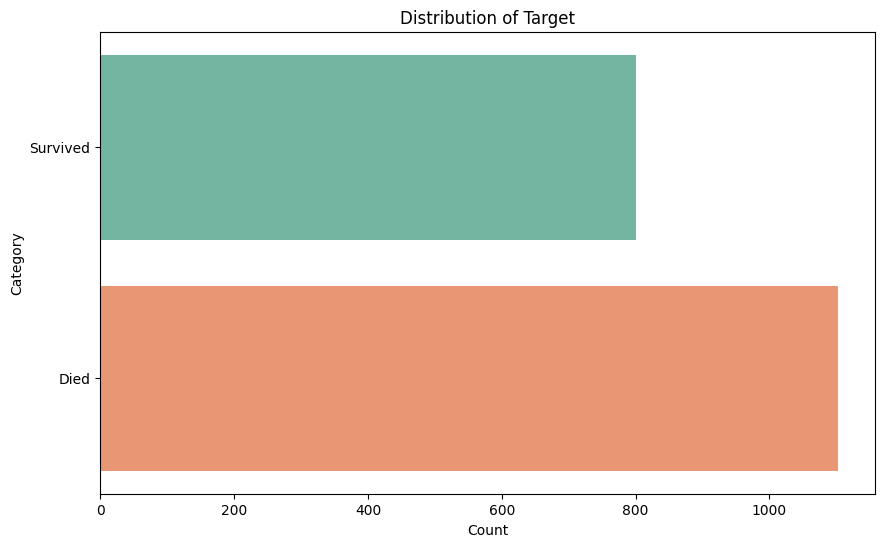

In [ ]:
# check the target distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='overall_survival', data=df_copy, palette='Set2')
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Distribution of Target')
plt.show()

- From the above count plot, we can see that our dataset is slightly imbalanced with more samples towards Death label.

**This distribution provides valuable information about the prevalence of the event in your dataset and can be used to better understand the underlying patterns and relationships in your data.**

In [ ]:
df.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,ush2a_mut,ryr2_mut,dnah5_mut,herc2_mut,pde4dip_mut,akap9_mut,tg_mut,birc6_mut,utrn_mut,tbx3_mut,col6a3_mut,arid1a_mut,lama2_mut,notch1_mut,cbfb_mut,ncor2_mut,col12a1_mut,col22a1_mut,pten_mut,akt1_mut,atr_mut,thada_mut,ncor1_mut,stab2_mut,myh9_mut,runx1_mut,nf1_mut,map2k4_mut,ros1_mut,lamb3_mut,arid1b_mut,erbb2_mut,sf3b1_mut,shank2_mut,ep300_mut,ptprd_mut,u

## Clinical Data Analysis

In [ ]:
def plot_num_var(LC_data,colname,name):
    # Visualizing our dependent variable and Skewness
    fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.set_facecolor("lightgrey")

    font_family = 'sans-serif'
    sns.boxplot(y= colname,x='overall_survival',data=LC_data,ax=ax1)
    ax1.set_ylabel(name, fontsize=14,family = font_family)
    ax1.set_xlabel('overall_survival', fontsize=14,family = font_family, fontweight="bold")
    ax1.set_title(name + ' by target', fontweight="bold",fontsize=15,family = font_family)

    sns.distplot(LC_data[colname],color='y',ax=ax2,kde=True)

    mean = np.mean(LC_data[colname].dropna().tolist())
    median = LC_data[colname].median()
    mode = LC_data[colname].mode()[0]

    label_mean= ("Mean :  {:.2f}".format(mean))
    label_median = ("Median :  {:.2f}".format(median))
    label_mode = ("Mode :  {:.2f}".format(mode))

    ax2.set_title("Distribution of " + name, fontweight="bold",fontsize=15,family = font_family)
    ax2.set_ylabel('Density', fontsize=12,family = font_family)
    ax2.set_xlabel(name, fontsize=12,family = font_family)
    ax2.axvline(mean,color="g",label=label_mean)
    ax2.axvline(median,color="b",label=label_median)
    ax2.axvline(mode,color="r",label=label_mode)
    ax2.legend()
    plt.savefig(f"{name}.png", bbox_inches='tight')
    plt.show()

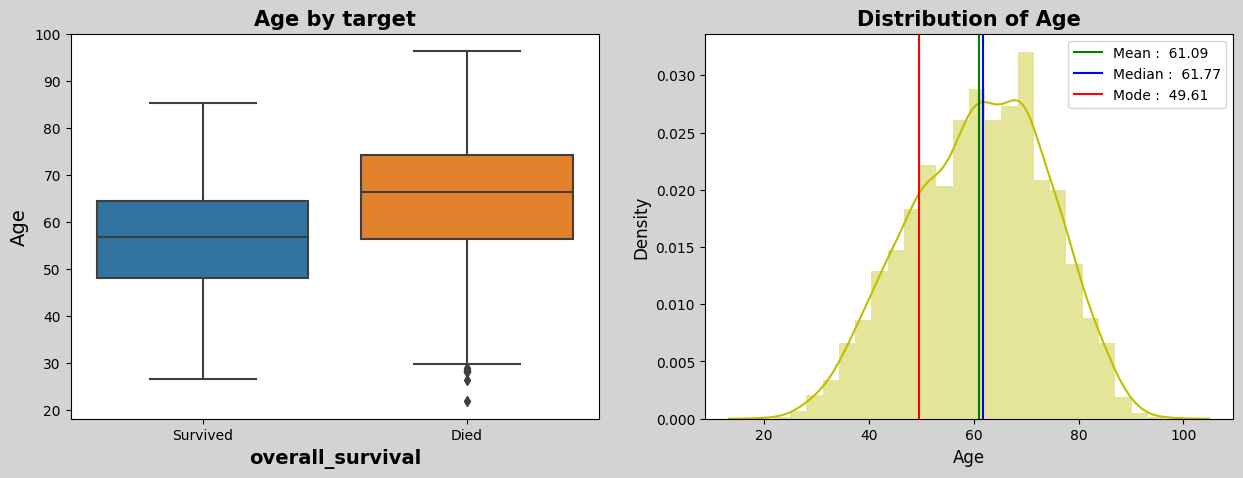

In [ ]:
df1 = df.copy()
df1['overall_survival'] = df1['overall_survival'].map({0:'Died', 1:'Survived'})
plot_num_var(df1,'age_at_diagnosis','Age')

* The mean value of age is 61.09.
* Patients who passed away due to breast cancer are older compared to the survived patients.

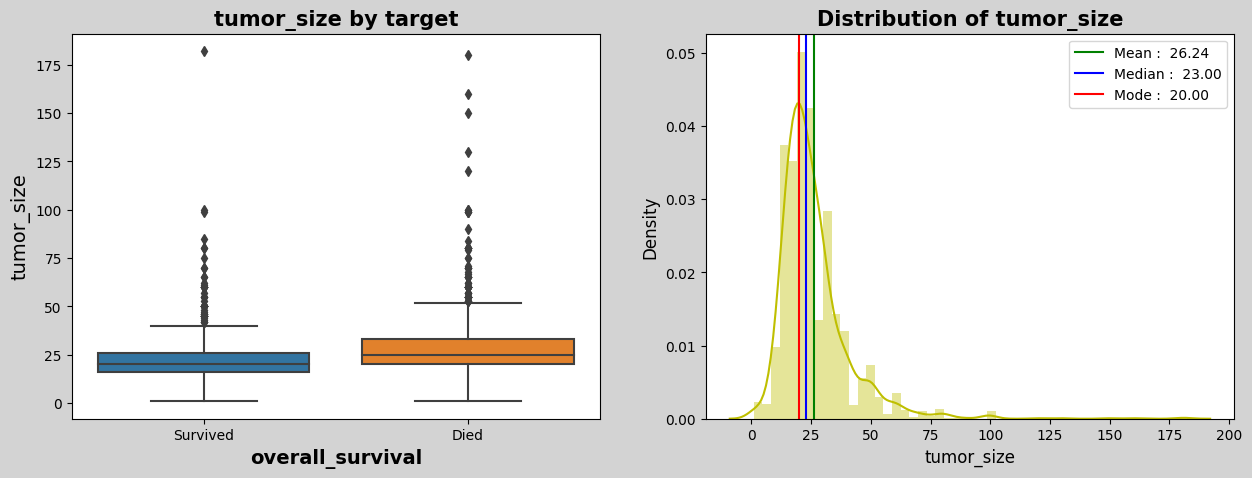

In [ ]:
plot_num_var(df1,'tumor_size','tumor_size')

* The box plot analysis reveals that patients who unfortunately did not survive tend to exhibit larger tumor sizes when compared to those who survived.

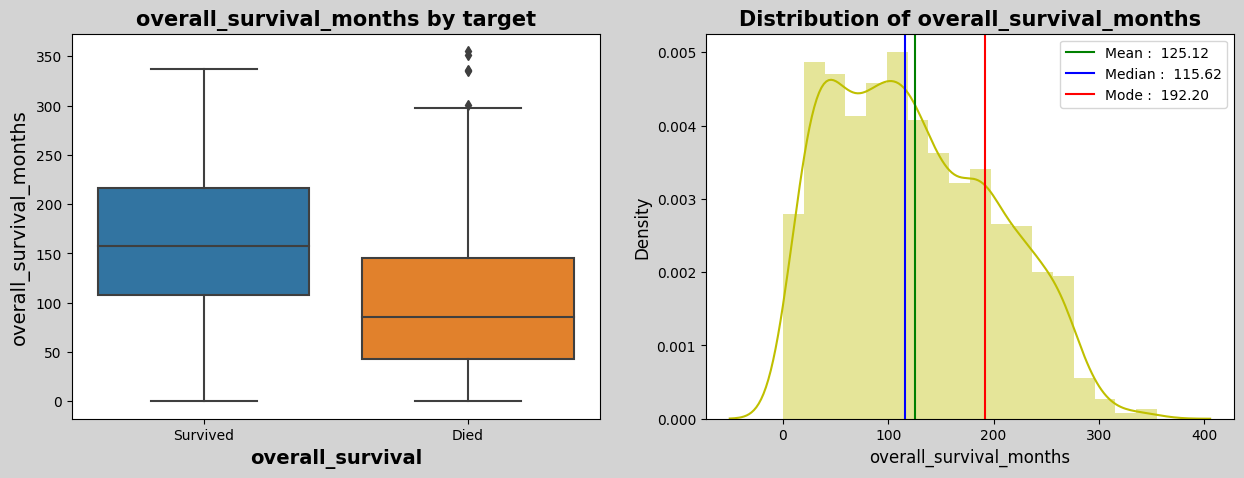

In [ ]:
plot_num_var(df1,'overall_survival_months','overall_survival_months')

In [ ]:
# create a new dataframe for clinical attributes only
clinical_features_to_drop = df.columns[30:] # non clinical attributes
clinical_df = df.drop(clinical_features_to_drop, axis=1)
clinical_df.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,brca1
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,-1.3990
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,-1.3800
2,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,0.0670
3,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,0.6744
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,1.2932


In [ ]:
df = clinical_df.copy()

In [ ]:
numeric_features = []
categorical_features = []

#splitting features into numeric and categoric
'''
whicheve feature has more than 10 category appending on mumeric_featrues and remaining are appending in categoric_features
'''

for col in df.columns:
  if df[col].nunique()>15:
    numeric_features.append(col)
  else:
    categorical_features.append(col)

print(f'numeric feature : {numeric_features}')
print(f'category feature : {categorical_features}')

numeric feature : ['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size', 'brca1']
category feature : ['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'oncotree_code', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_stage']


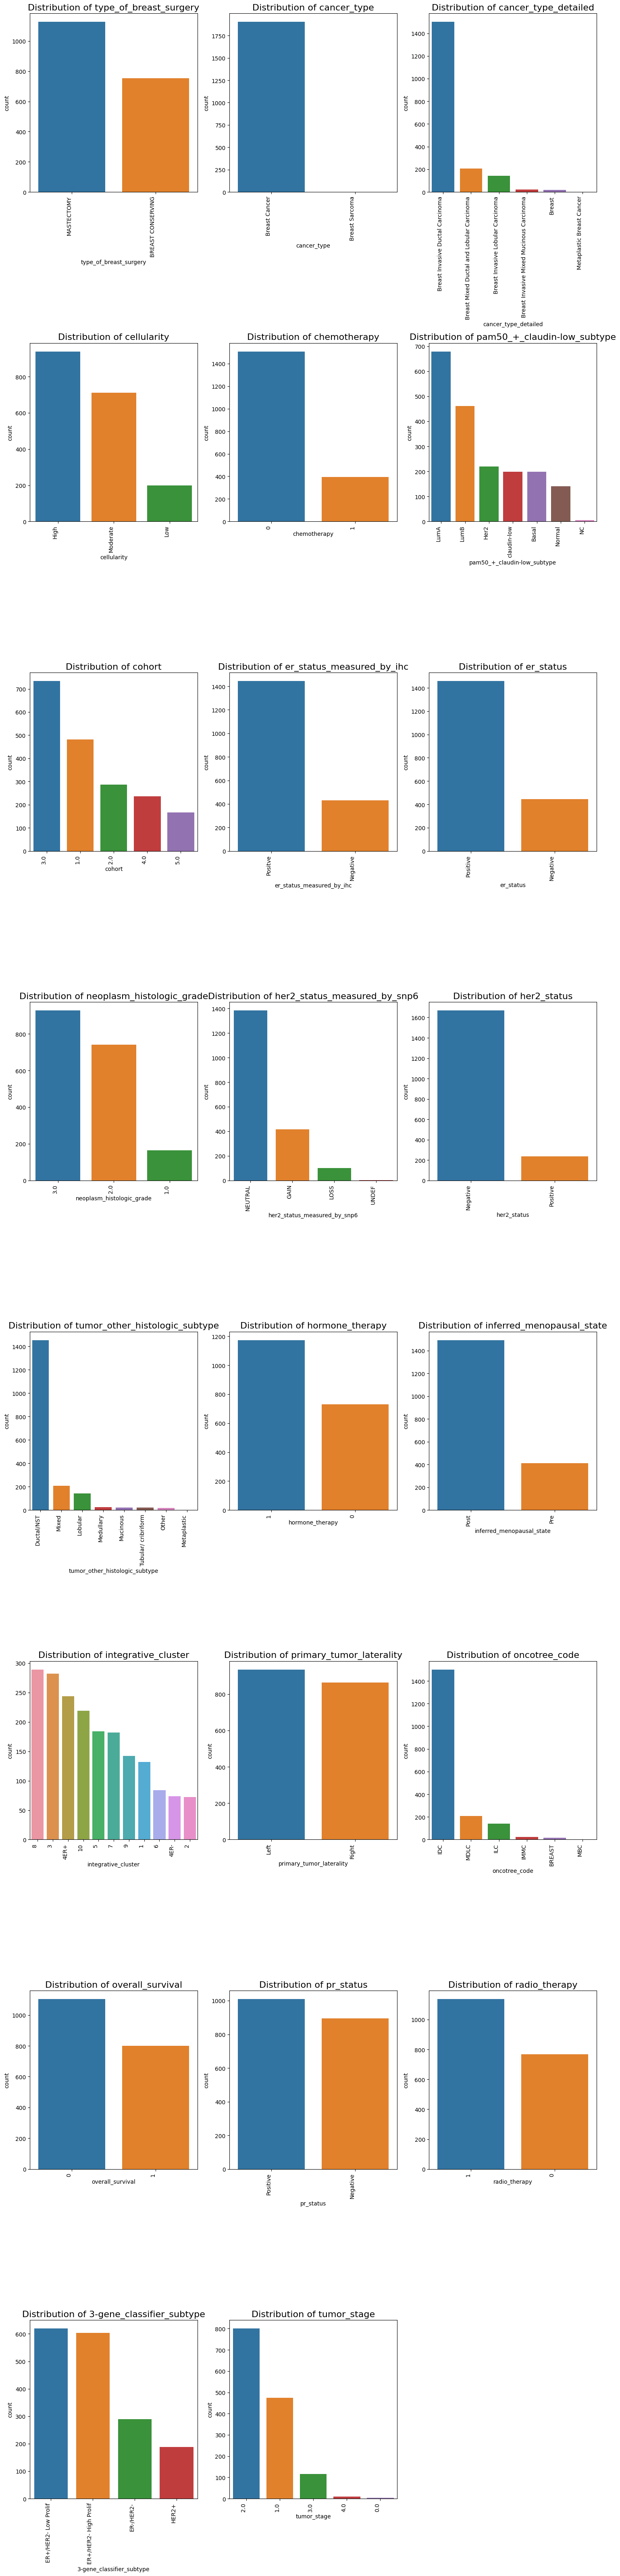

In [ ]:
# List of categorical features
categorical_features = categorical_features

plots_per_row = 3
num_rows = len(categorical_features) // plots_per_row + 1

plt.figure(figsize=(15, 8 * num_rows))

# Create subplots and plot each categorical feature
for i, feature in enumerate(categorical_features):
    plt.subplot(num_rows, plots_per_row, i + 1)
    ax = sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
    plt.title(f"Distribution of {feature}", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.tight_layout()
plt.show()

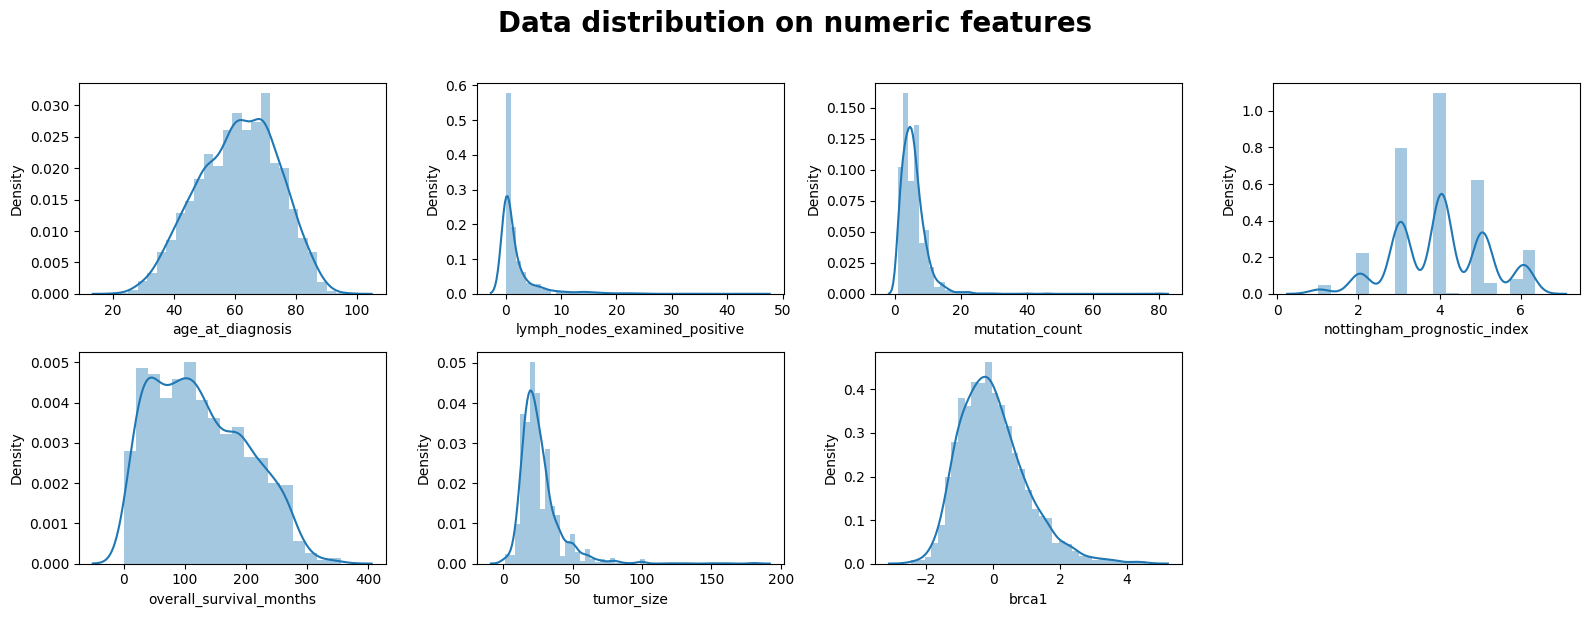

In [ ]:
plt.figure(figsize=(16,6))
plt.suptitle('Data distribution on numeric features',fontsize=20,fontweight='bold',y=1.02)

for i,col in enumerate(numeric_features):
  plt.subplot(2,4,i+1)
  a = sns.distplot(df[col])
  plt.xlabel(col)
  plt.tight_layout()

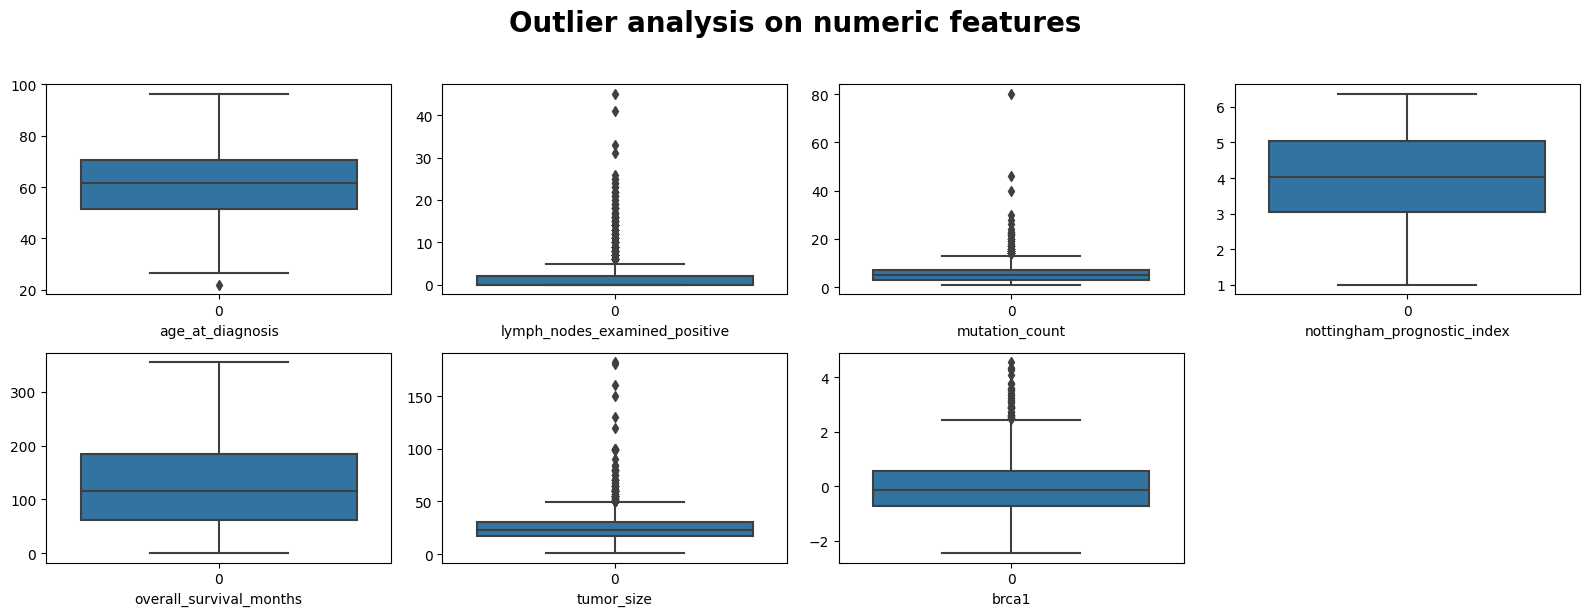

In [ ]:
plt.figure(figsize=(16,6))
plt.suptitle('Outlier analysis on numeric features',fontsize=20,fontweight='bold',y=1.02)

for i, col in enumerate(numeric_features):
  plt.subplot(2,4,i+1)
  sns.boxplot(df[col])
  plt.xlabel(col)
  plt.tight_layout()

* As you can see outlier present in [lymph_nodes_examined_positive, mutation_count, tumor_size, brca1] attributes.

### Dealing with missing values

In [ ]:
df_missing = df[missing_values_info.index.tolist()]
print('_____________________________________________________')
print("\nBefore Handling Missing Values Count :", df_missing.isnull().sum().sum())
print('_____________________________________________________')

_____________________________________________________

Before Handling Missing Values Count : 1099
_____________________________________________________


In [ ]:
# Calculate the count of unique values for each column
unique_value_counts = df_missing.nunique()
unique_counts_df = pd.DataFrame({'Column': unique_value_counts.index, 'Unique Count': unique_value_counts.values})
unique_counts_df

,Column,Unique Count
0,tumor_stage,5
1,3-gene_classifier_subtype,4
2,primary_tumor_laterality,2
3,neoplasm_histologic_grade,3
4,cellularity,3
5,mutation_count,30
6,er_status_measured_by_ihc,2
7,type_of_breast_surgery,2
8,tumor_size,111
9,cancer_type_detailed,6


In [ ]:
integer_cols = ['tumor_size']
categorical_cols__ = ['tumor_stage',
 '3-gene_classifier_subtype',
 'primary_tumor_laterality',
 'neoplasm_histologic_grade',
 'cellularity',
 'mutation_count',
 'er_status_measured_by_ihc',
 'type_of_breast_surgery',
 'cancer_type_detailed',
 'tumor_other_histologic_subtype',
 'oncotree_code']

In [ ]:
# filling the numeric features with mean/average value
df[integer_cols] = df[integer_cols].fillna(df[integer_cols].astype(float).mean()).astype(int)

# Iterate through each categorical column and fill missing values with the most frequent value
for col in categorical_cols__:
    most_frequent_value = df[col].value_counts().index[0]
    df[col].fillna(most_frequent_value, inplace=True)

In [ ]:
print('_____________________________________________________')
print("After Handling Missing Values Count :", df.isnull().sum().sum())
print('_____________________________________________________')

_____________________________________________________
After Handling Missing Values Count : 0
_____________________________________________________


In [ ]:
df.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,brca1
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,5.0,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22,2.0,-1.3990
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10,1.0,-1.3800
2,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,Positive,0,ER+/HER2- Low Prolif,15,2.0,0.0670
3,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,Positive,1,ER+/HER2- Low Prolif,25,2.0,0.6744
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40,2.0,1.2932


### Treating Outliers

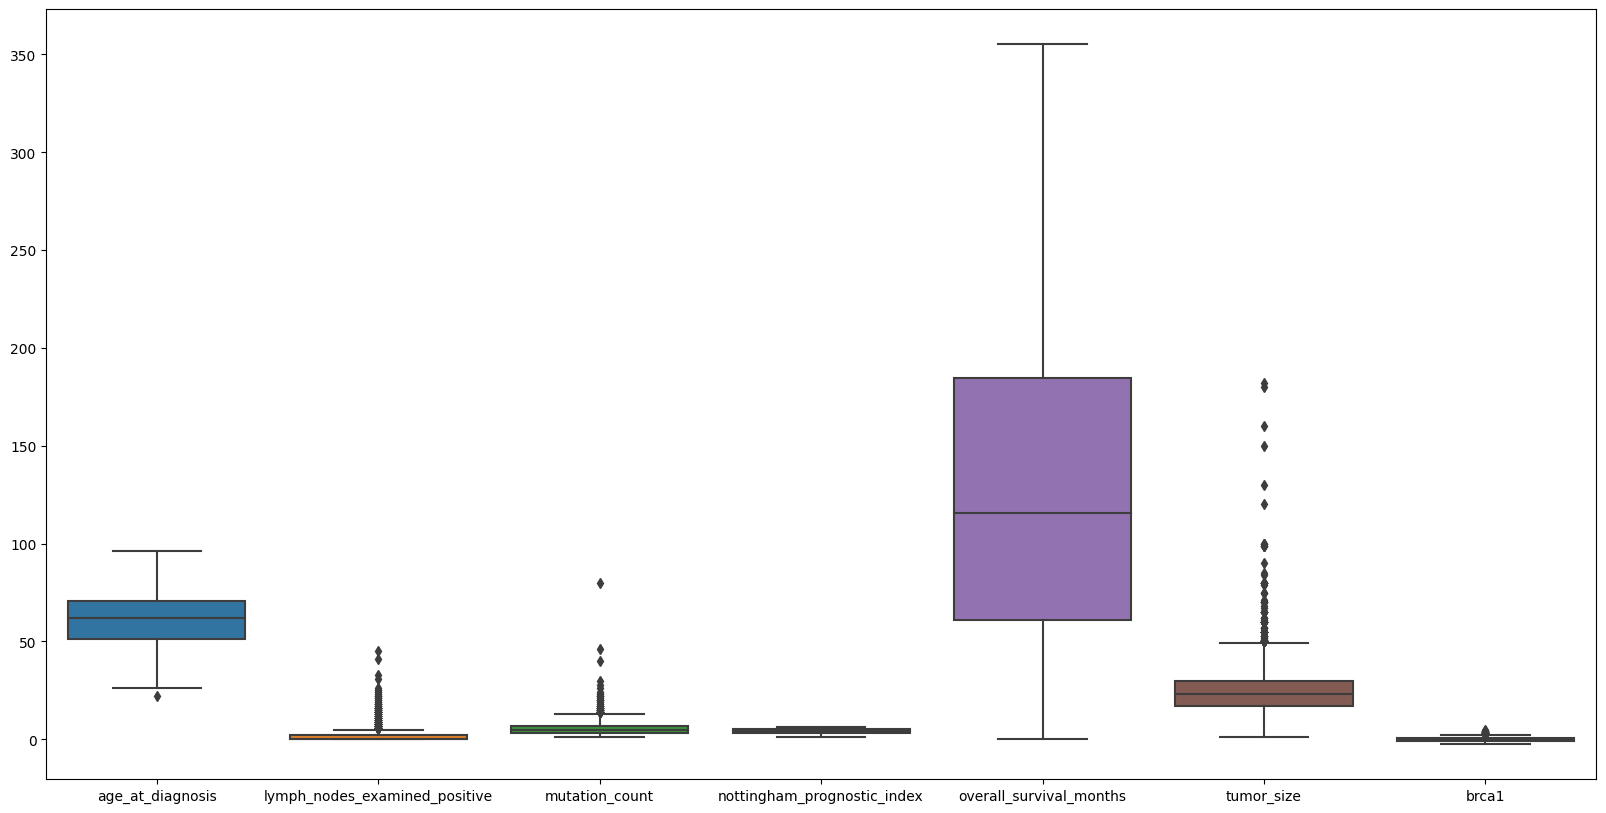

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df[numeric_features])
plt.show()

#### Capping method
* A capping method is a technique used to handle extreme values(outliers) in a dataset that may be causing issues with the analysis or modeling of the data. In one capping method we replace outliers with a maximum or minimum value that is within a certain range of the other values in the dataset.

* For example, if the majority of values in a dataset fall between 0 and 100, an outlier value of 1000 could be replaced with a value of 100 to prevent it from skewing the results. Other capping methods include truncating the values at a specified percentile, or using a robust measure of central tendency such as the median instead of the mean.

In [ ]:
for col in numeric_features:
  #using IQR method to define the range of upper and lower limit
  IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
  upper_limit = df[col].quantile(0.75) + (1.5*IQR)
  lower_limit = df[col].quantile(0.25) - (1.5*IQR)
  # replcing with upper_limit, if outlier is higher than upper_limit.
  df[col] = np.where(df[col]>upper_limit, upper_limit, df[col])

  # replcing with lower_limit, if outlier is lesser than lower_limit.
  df[col] = np.where(df[col]<lower_limit, lower_limit, df[col])

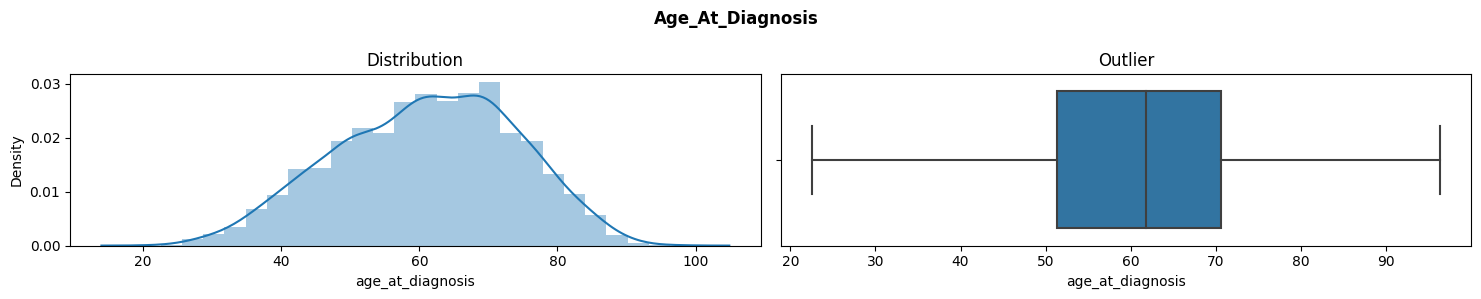

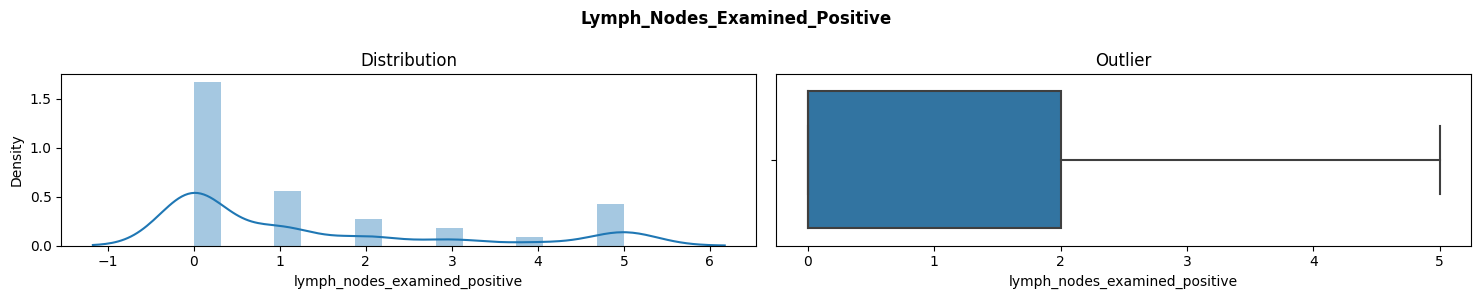

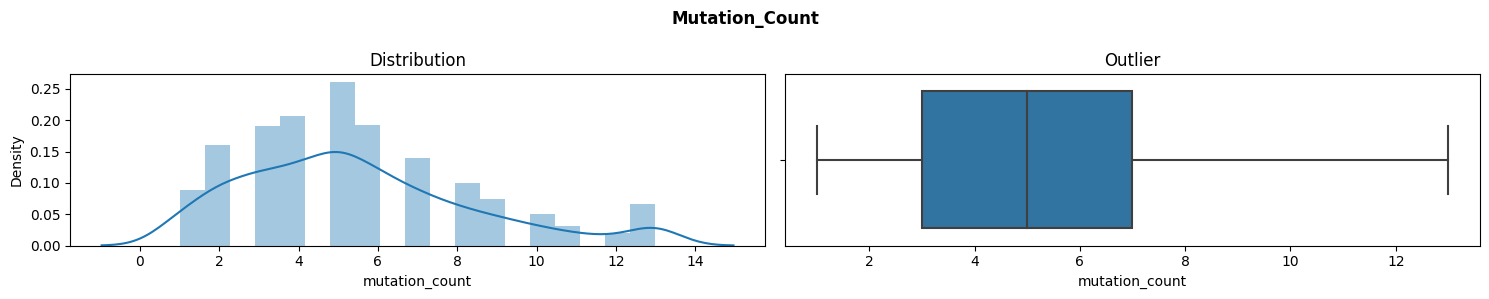

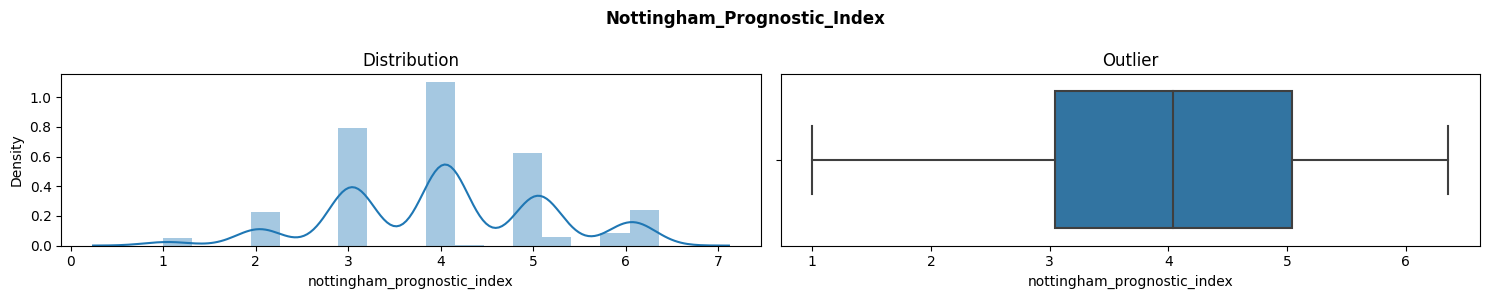

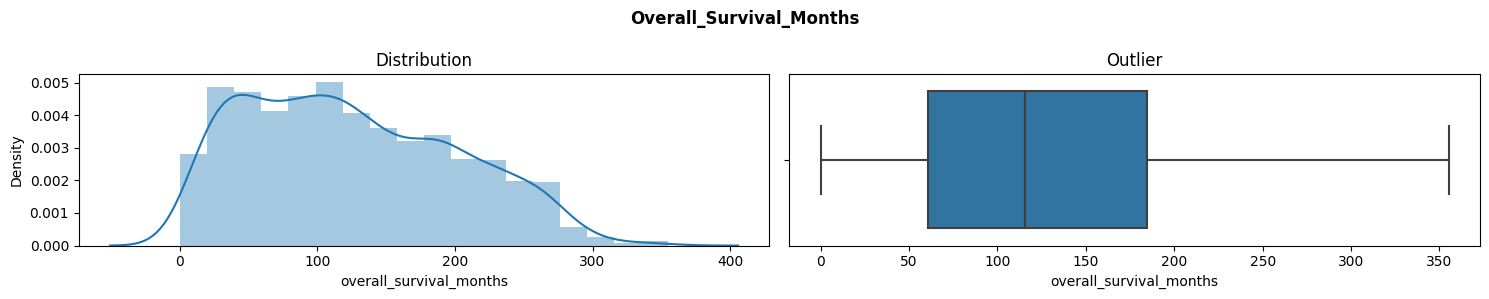

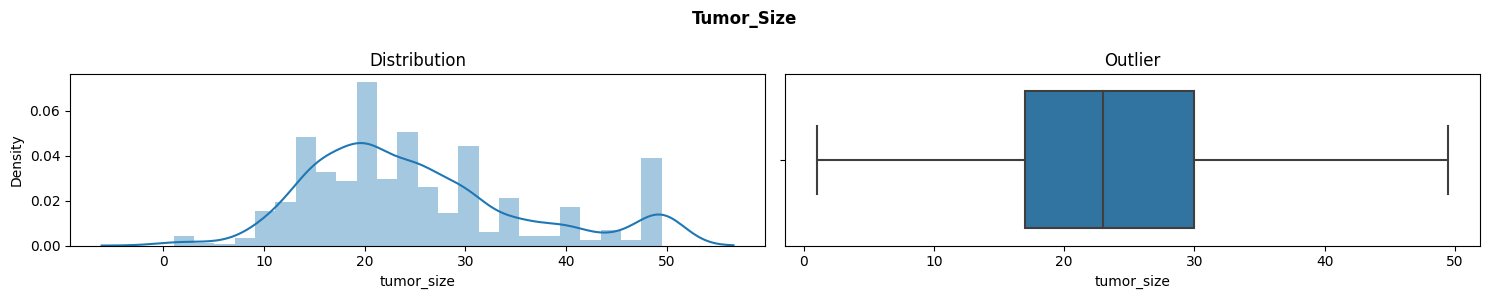

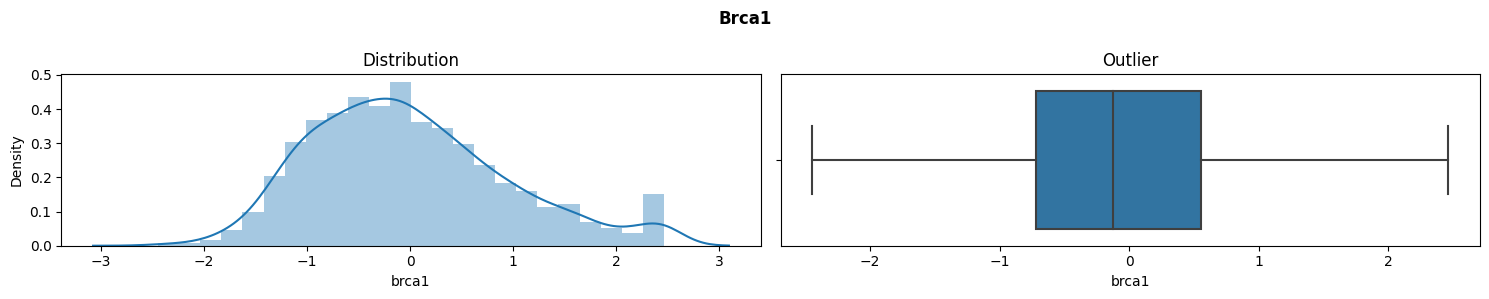

In [ ]:
# checking for outliers after treating them.
for col in numeric_features:
  fig, ax =plt.subplots(1,2, figsize=(15,3))
  sns.distplot(df[col], ax=ax[0]).set(title="Distribution")
  sns.boxplot(x= col,data=df, ax=ax[1]).set(title="Outlier")
  plt.suptitle(f'{col.title()}',weight='bold')
  plt.tight_layout()

## Label Encoding

* Label encoding is a process of transforming categorical variables into numerical representations. In machine learning and data analysis, many algorithms require numerical inputs, and label encoding provides a way to convert categorical data into a suitable format.
* We are using label encoding deal with the categorical variables in our dataset.

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
for col in categorical_features:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)  # Convert boolean to integer (0 or 1)
    else:
        df[col] = labelEncoder.fit_transform(df[col])

###  Correlation between clinical attributes and label

<Axes: >

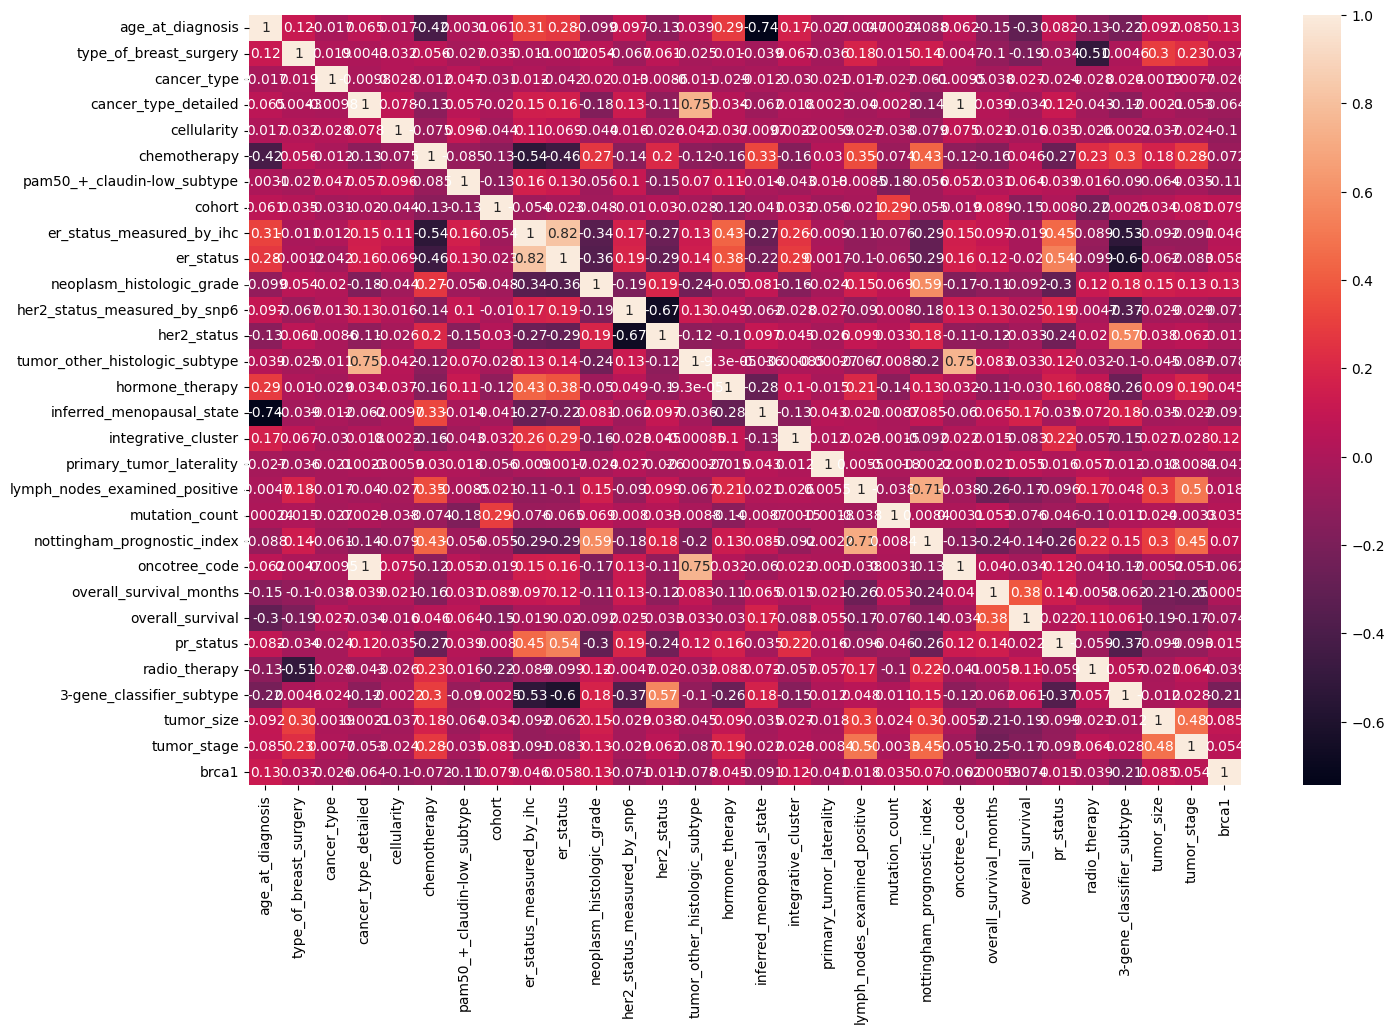

In [ ]:
# Plotting correlation heatmap
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), annot=True)

In [ ]:
def check_correlation(df):
  # Calculate the correlation matrix
  correlation_matrix = df.corr()[['overall_survival']].sort_values(by='overall_survival', ascending=False)

  # Rename the correlation column to 'Correlation with Energy Usage'
  correlation_matrix = correlation_matrix.rename(columns={'overall_survival': 'Correlation with Overall Survival'})

  # Display the correlation matrix as a table
  print("Correlation Matrix:")
  print(correlation_matrix)
  return correlation_matrix

In [ ]:
# Calculate the correlation matrix
correlation_matrix = check_correlation(df)

Correlation Matrix:
                                Correlation with Overall Survival
overall_survival                                         1.000000
overall_survival_months                                  0.384467
inferred_menopausal_state                                0.170915
radio_therapy                                            0.112083
pam50_+_claudin-low_subtype                              0.063790
3-gene_classifier_subtype                                0.061270
primary_tumor_laterality                                 0.055441
chemotherapy                                             0.045625
tumor_other_histologic_subtype                           0.032734
cancer_type                                              0.026900
her2_status_measured_by_snp6                             0.024611
pr_status                                                0.022425
cellularity                                             -0.016356
er_status_measured_by_ihc                               

* The correlation matrix reveals relationships between features and 'Overall Survival.' Positive correlations, like 'overall_survival_months' and 'radio_therapy,' suggest potential benefits for survival. Conversely, 'age_at_diagnosis' and tumor-related features like 'tumor_size' exhibit negative correlations, indicating potential adverse effects on survival. These insights highlight a complex interplay of factors influencing patient outcomes, guiding further analysis toward key predictors and treatment strategies for improved prognosis in breast cancer cases.

In [ ]:
def drop_high_categrocal_features(df, threshold=95):
  # lets remove the features which has only one category value equal to 100% and missing value >=95%
  # because that are not good for model prediction
  stats = []
  for col in df.columns[:-1]:
      stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
  stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', '% MissingValues', '% highOneCategoricalValues', 'type'])
  df_ = stats_df.sort_values('% MissingValues', ascending=False)
  one_category_value = df_[(df_['% highOneCategoricalValues']>=threshold) | (df_['% MissingValues']>=95)]
  print(tabulate(one_category_value, headers = 'keys', tablefmt = 'psql'))
  return one_category_value

* The function drop_high_categorical_features(df, threshold=95) helps remove categorical features from the DataFrame df that have a missing value percentage exceeding the specified threshold of 95%.

In [ ]:
one_category_value = drop_high_categrocal_features(df, threshold=95)

+----+-------------+-----------------+-------------------+------------------------------+--------+
|    | Feature     |   Unique_values |   % MissingValues |   % highOneCategoricalValues | type   |
|----+-------------+-----------------+-------------------+------------------------------+--------|
|  2 | cancer_type |               2 |                 0 |                      99.9475 | int64  |
+----+-------------+-----------------+-------------------+------------------------------+--------+


In [ ]:
drop_features = one_category_value['Feature'].tolist()
print(drop_features)

['cancer_type']


In [ ]:
# lets drop the features
df = df.drop(drop_features, axis=1)

In [ ]:
df.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,brca1
0,75.65,1,1,0,0,6,0,1,1,2,2,0,0,1,0,4,1,5.0,5.0,6.044,1,140.500000,1,0,1,2,22.0,2,-1.3990
1,43.19,0,1,0,0,2,0,1,1,2,2,0,0,1,1,4,1,0.0,2.0,4.020,1,84.633333,1,1,1,0,10.0,1,-1.3800
2,48.87,1,1,0,1,3,0,1,1,1,2,0,0,1,1,3,1,1.0,2.0,4.030,1,163.700000,0,1,0,1,15.0,2,0.0670
3,47.68,1,4,2,1,3,0,1,1,1,2,0,4,1,1,10,1,3.0,1.0,4.050,5,164.933333,1,1,1,1,25.0,2,0.6744
4,76.97,1,4,0,1,3,0,1,1,2,2,0,4,1,0,10,1,5.0,2.0,6.080,5,41.366667,0,1,1,0,40.0,2,1.2932


In [ ]:
df_copy = df.copy()

In [ ]:
# lets extract the dependent and independent features
X = df_copy.drop('overall_survival', axis=1)
y = df_copy['overall_survival']

In [ ]:
import random
np.random.seed(42)
random.seed(42)

### Split Train Test

- The purpose of this split is to allow you to train your model on one set of data and then evaluate its performance on another set of data that it hasn't seen before.

- The most common split is a 70/30 or 80/20 split, where the larger portion is used for training the model and the smaller portion is used for evaluating its performance. The training set is used to fit the model to the data, while the testing set is used to evaluate the model's performance in making predictions on new, unseen data.

- **So, we decide to split the dataset 80% for training and 20% for testing.**

In [ ]:
def splitting_dataset(X, y, test_size=0.20):
    from sklearn.model_selection import train_test_split

    assert X.shape[0] == y.shape[0], "Number of samples in X and y should be the same."

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # Check the shape of training and testing sets
    print("Training shape:", X_train.shape)
    print("Testing shape:", X_test.shape)

    return X_train, X_test, y_train, y_test

In [ ]:
# lets split the dataset stratified
X_train, X_test, y_train, y_test = splitting_dataset(X, y , test_size=0.2)

Training shape: (1523, 28)
Testing shape: (381, 28)


### Normalize the Data
* Normalization, in the context of data analysis and machine learning, refers to the process of transforming numerical data into a standardized scale. The goal of normalization is to bring different features or variables onto a similar scale to ensure fair comparisons and improve the performance of certain algorithms.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [ ]:
X_train.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,brca1
996,-0.861411,1,1,2,0,2,2,1,1,1,2,0,0,1,1,3,0,-0.161049,-0.498192,0.000759,1,1.002736,1,0,1,-1.381643,2,0.217783
31,-1.084294,1,2,2,0,5,0,1,1,1,2,0,1,1,1,9,1,-0.726203,-0.836465,-0.835530,2,0.297208,1,1,1,0.823484,2,-1.436609
796,-0.517025,1,1,2,0,3,2,1,1,2,2,0,0,0,0,4,0,-0.726203,0.178354,0.035898,1,-0.995676,1,1,0,0.455963,2,0.550127
457,-0.174187,1,2,2,0,6,0,1,1,1,2,0,1,1,0,4,0,-0.726203,-0.159919,-0.719574,2,-1.246900,0,1,1,2.247628,2,-1.755446
1146,-2.179363,0,1,2,1,6,2,0,0,2,2,0,0,1,1,1,0,2.099568,0.178354,1.775240,1,-1.385204,0,1,2,-0.462840,2,-0.305968


# Model Building

- **When evaluating the performance of classification, there are several evaluation metrics and techniques you can use. Here are some commonly used ones:**

**Classification Metrics:**

**Accuracy:** It measures the overall correctness of the classification model by calculating the ratio of correctly classified instances to the total number of instances.<br>
**Precision:** It measures the proportion of correctly predicted positive instances out of the total instances predicted as positive. It focuses on the quality of the positive predictions.<br>
**Recall (Sensitivity):** It measures the proportion of correctly predicted positive instances out of the total actual positive instances. It focuses on the coverage of positive instances.<br>
**F1 Score:** It is the harmonic mean of precision and recall, providing a balanced measure of the model's performance.<br>
**Classification Report:** It provides a comprehensive summary of the precision, recall, F1 score, and support for each class, giving insights into the performance of the model for each class.<br>
**Confusion Matrix:** It displays the counts of true positive, false positive, true negative, and false negative predictions, providing a detailed view of the model's performance

In [ ]:
# Import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import time
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
# empty list for appeding performnace metric score
model_result = []

def predict(ml_model, model_name):

  '''
  Pass the model and predict value.
  Function will calculate all the eveluation metrics and appending those metrics score on model_result table.
  Plotting confusion_matrix and roc_curve for test data.
  '''

  # model fitting
  model = ml_model.fit(X_train, y_train)

  # predicting value and probability
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  y_train_prob = model.predict_proba(X_train)[:,1]
  y_test_prob = model.predict_proba(X_test)[:,1]


  ''' Performance Metrics '''
  # accuracy score  ---->  TP+TN/TP+FP+TN+FN
  train_accuracy = accuracy_score(y_train, y_train_pred)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print(f'train accuracy : {round(train_accuracy,3)}')
  print(f'test accuracy : {round(test_accuracy,3)}')

  # precision score  ---->  TP/TP+FP
  train_precision = precision_score(y_train, y_train_pred)
  test_precision = precision_score(y_test, y_test_pred)
  # print(f'train precision : {round(train_precision,3)}')
  print(f'test precision : {round(test_precision,3)}')

  # recall score  ---->  TP/TP+FN
  train_recall = recall_score(y_train, y_train_pred)
  test_recall = recall_score(y_test, y_test_pred)
  # print(f'train recall : {round(train_recall,3)}')
  print(f'test recall : {round(test_recall,3)}')

  # f1 score  ---->  Harmonic Mean of Precision and Recall
  train_f1 = f1_score(y_train, y_train_pred)
  test_f1 = f1_score(y_test, y_test_pred)
  # print(f'train f1 : {round(train_f1,3)}')
  print(f'test f1 : {round(test_f1,3)}')

  # roc_auc score  ---->  It tells how much the model is capable of distinguishing between classes.
  train_roc_auc = roc_auc_score(y_train, y_train_prob)
  test_roc_auc = roc_auc_score(y_test, y_test_prob)
  # print(f'train roc_auc : {round(train_roc_auc,3)}')
  print(f'test roc_auc : {round(test_roc_auc,3)}')
  print('-'*80)

  # classificatio report
  print(f'classification report for test data \n{classification_report(y_test, y_test_pred)}')
  print('-'*80)


  ''' plotting Confusion Matrix '''
  ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
  plt.title('confusion matrix on Test data', weight='bold')
  plt.show()
  print('-'*80)


  ''' plotting ROC curve '''
  fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
  plt.plot(fpr,tpr, label=f'ROC - {model_name}')
  plt.plot([0,1], [0,1], '--')
  plt.title('ROC curve on Test data', weight='bold')
  plt.xlabel('False Positive Rate----->')
  plt.ylabel('True Positive Rate----->')
  plt.legend(loc=4)


  ''' actual value vs predicted value on test data'''
  d = {'y_actual':y_test, 'y_predict':y_test_pred}
  print(pd.DataFrame(data=d).head(10).T) # creating dataframe including actual value and predicted value
  print('-'*80)


  # appneding performance metrics score to make final model_result.
  model_result.append({'model':model_name,
                       'train_accuracy':train_accuracy,
                       'test_accuracy':test_accuracy,
                      #  'train_precision':train_precision,
                       'test_precision':test_precision,
                      #  'train_recall':train_recall,
                       'test_recall':test_recall,
                      #  'train_f1':train_f1,
                       'test_f1':test_f1,
                      #  'train_roc_auc':train_roc_auc,
                       'test_roc_auc':test_roc_auc})

train accuracy : 0.765
test accuracy : 0.74
test precision : 0.689
test recall : 0.667
test f1 : 0.678
test roc_auc : 0.804
--------------------------------------------------------------------------------
classification report for test data 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       225
           1       0.69      0.67      0.68       156

    accuracy                           0.74       381
   macro avg       0.73      0.73      0.73       381
weighted avg       0.74      0.74      0.74       381

--------------------------------------------------------------------------------


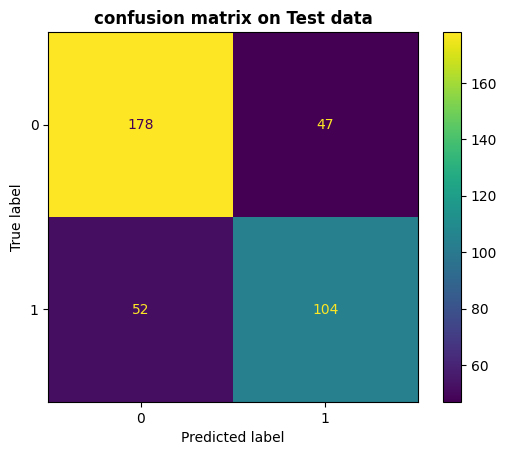

--------------------------------------------------------------------------------
           829   670   1064  85    1814  1148  1727  1070  898   175 
y_actual      0     0     0     0     1     0     1     0     0     0
y_predict     0     0     0     0     0     0     0     1     0     0
--------------------------------------------------------------------------------


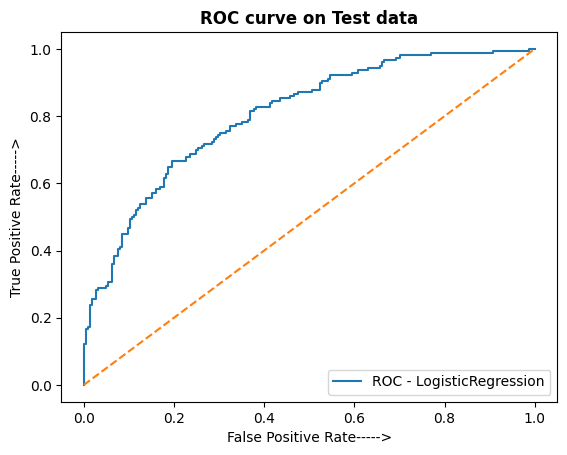

In [ ]:
predict(LogisticRegression(), 'LogisticRegression')

train accuracy : 0.947
test accuracy : 0.79
test precision : 0.753
test recall : 0.724
test f1 : 0.739
test roc_auc : 0.859
--------------------------------------------------------------------------------
classification report for test data 
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       225
           1       0.75      0.72      0.74       156

    accuracy                           0.79       381
   macro avg       0.78      0.78      0.78       381
weighted avg       0.79      0.79      0.79       381

--------------------------------------------------------------------------------


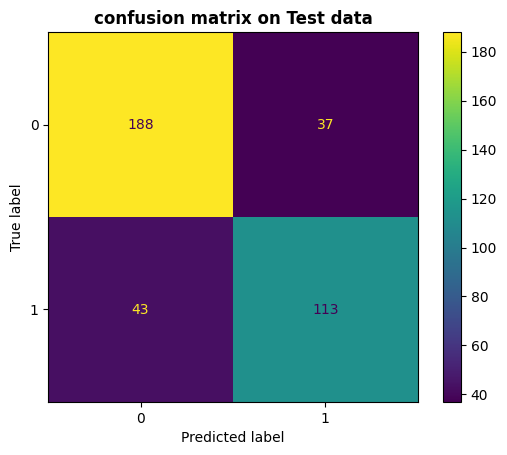

--------------------------------------------------------------------------------
           829   670   1064  85    1814  1148  1727  1070  898   175 
y_actual      0     0     0     0     1     0     1     0     0     0
y_predict     0     0     0     0     1     0     0     1     0     0
--------------------------------------------------------------------------------


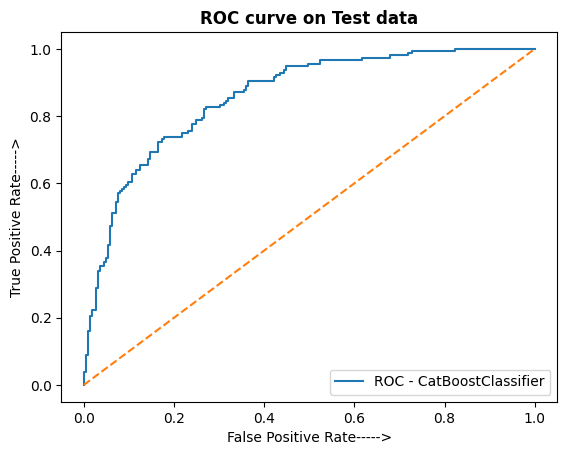

In [ ]:
predict(CatBoostClassifier(silent=True), 'CatBoostClassifier')

train accuracy : 1.0
test accuracy : 0.769
test precision : 0.75
test recall : 0.654
test f1 : 0.699
test roc_auc : 0.832
--------------------------------------------------------------------------------
classification report for test data 
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       225
           1       0.75      0.65      0.70       156

    accuracy                           0.77       381
   macro avg       0.76      0.75      0.76       381
weighted avg       0.77      0.77      0.77       381

--------------------------------------------------------------------------------


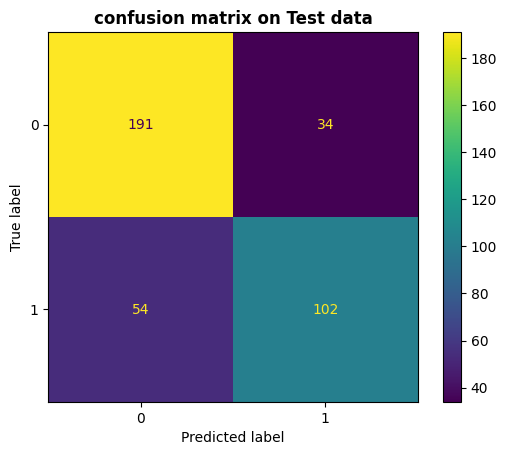

--------------------------------------------------------------------------------
           829   670   1064  85    1814  1148  1727  1070  898   175 
y_actual      0     0     0     0     1     0     1     0     0     0
y_predict     0     0     0     0     0     0     0     0     0     0
--------------------------------------------------------------------------------


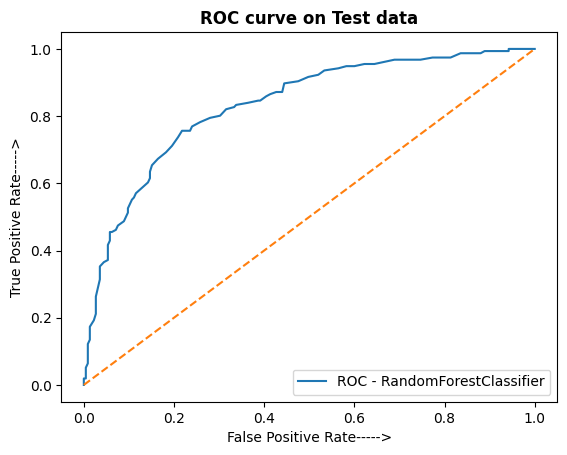

In [ ]:
predict(RandomForestClassifier(), 'RandomForestClassifier')

train accuracy : 0.806
test accuracy : 0.659
test precision : 0.587
test recall : 0.564
test f1 : 0.575
test roc_auc : 0.706
--------------------------------------------------------------------------------
classification report for test data 
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       225
           1       0.59      0.56      0.58       156

    accuracy                           0.66       381
   macro avg       0.65      0.64      0.65       381
weighted avg       0.66      0.66      0.66       381

--------------------------------------------------------------------------------


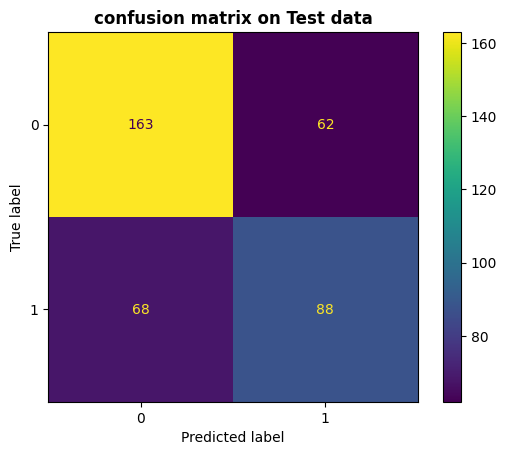

--------------------------------------------------------------------------------
           829   670   1064  85    1814  1148  1727  1070  898   175 
y_actual      0     0     0     0     1     0     1     0     0     0
y_predict     0     0     0     1     0     0     1     0     0     0
--------------------------------------------------------------------------------


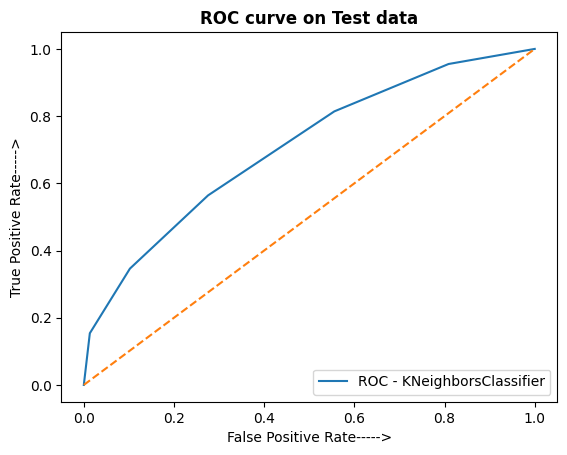

In [ ]:
predict(KNeighborsClassifier(), 'KNeighborsClassifier')

In [ ]:
model_result__ = round(pd.DataFrame(model_result),3)
model_result__

,model,train_accuracy,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,LogisticRegression,0.765,0.740,0.689,0.667,0.678,0.804
1,CatBoostClassifier,0.947,0.790,0.753,0.724,0.739,0.859
2,RandomForestClassifier,1.000,0.769,0.750,0.654,0.699,0.832
3,KNeighborsClassifier,0.806,0.659,0.587,0.564,0.575,0.706


### Hyperparameter Tuning

In [ ]:
def hyperparamater_tuning(clf, X_train, y_train , param_grid, cv = 5):
  # Initialize the GridSearchCV object
  grid = GridSearchCV(clf, param_grid, cv=cv)

  # Fit the model to the training data and tune the hyperparameters
  grid.fit(X_train, y_train)

  # Print the accuracy for each combination of parameters
  for mean_score, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
      print(params, ":", mean_score)

  # Print the best parameters
  print("Best parameters: ", grid.best_params_)
  return grid.best_params_, grid.best_estimator_

In [ ]:
param_grid = {
    'iterations': [50, 100, 150],  # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.5],  # Step size at each boosting iteration
    'depth': [4, 6, 8],  # Depth of the trees in the model
    'l2_leaf_reg': [1, 3, 5],  # L2 regularization coefficient
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio for each boosting iteration
    'colsample_bylevel': [0.6, 0.8, 1.0]  # Subsample ratio of columns for each split
}

In [ ]:
# Initialize the classifier
clf = CatBoostClassifier(silent=True)
best_params_, optimal_model = hyperparamater_tuning(clf, X_train, y_train , param_grid)

In [ ]:
predict(CatBoostClassifier(**{'colsample_bylevel': 0.6, 'depth': 4, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'subsample': 0.8}), 'Tune-CatBoostClassifier')

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider for best split
}

# Initialize the classifier
clf = RandomForestClassifier()
best_params_, optimal_model = hyperparamater_tuning(clf, X_train, y_train , param_grid)

In [ ]:
predict(RandomForestClassifier(**{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}), 'Tune-RandomForestClassifier')

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting method for predictions
    'p': [1, 2]  # Parameter for the Minkowski distance metric (1 for Manhattan, 2 for Euclidean)
}

# Initialize the classifier
clf = KNeighborsClassifier()
best_params_, optimal_model = hyperparamater_tuning(clf, X_train, y_train , param_grid)

In [ ]:
predict(KNeighborsClassifier(**{'n_neighbors': 11, 'p': 2, 'weights': 'distance'}), 'Tune-KNeighborsClassifier')

In [ ]:
model_result__ = round(pd.DataFrame(model_result),3)
model_result__

# Oversampling


* SMOTE (Synthetic Minority Over-sampling Technique) is a resampling technique used in imbalanced datasets to address the issue of minority class under-representation. It works by generating synthetic samples for the minority class based on existing instances, effectively balancing class distribution. SMOTE creates new, synthetic instances by interpolating between existing minority class samples, mitigating class imbalance without replicating existing data. By introducing synthetic data points, SMOTE aims to improve model performance and prevent classifiers from being biased towards the majority class, thus enhancing the accuracy and reliability of predictive models in scenarios with imbalanced data distributions.

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
# lets extract the dependent and independent features
X = df_copy.drop('overall_survival', axis=1)
y = df_copy['overall_survival']

In [ ]:
# Print class distribution before resampling
print("Class distribution before resampling:", Counter(y))

# Oversampling using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

# Print class distribution after resampling
print("Class distribution after SMOTE oversampling:", Counter(y_resampled_smote))

In [ ]:
# Plotting the class distribution
labels = ['Original', 'SMOTE Oversampling']
counts = [Counter(y), Counter(y_resampled_smote)]

fig, axs = plt.subplots(1,2, figsize=(15, 5))

for i, (ax, count) in enumerate(zip(axs, counts)):
    ax.bar(['Class 0', 'Class 1'], [count[0], count[1]], color=['orange', 'blue'])
    ax.set_title(labels[i])
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')

plt.suptitle('Class Distribution Before and After Resampling', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# lets split the dataset stratified
X_train, X_test, y_train, y_test = splitting_dataset(X_resampled_smote, y_resampled_smote , test_size=0.2)

In [ ]:
numeric_features

In [ ]:
# normalize the data
scaler1 = StandardScaler()

X_train[numeric_features] = scaler1.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler1.transform(X_test[numeric_features])

In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize individual models
random_forest = RandomForestClassifier(**{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50})
catboost_ = CatBoostClassifier(**{'colsample_bylevel': 0.6, 'depth': 4, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'subsample': 0.8}, silent=True)

# Create the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('rf', random_forest), ('catboost', catboost_)],
    voting='soft'
)

In [ ]:
predict(voting_classifier, 'Hybrid Model (RF+Catboost)')

In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize individual models
random_forest = RandomForestClassifier(**{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50})
lr = LogisticRegression()

# Create the Voting Classifier
voting_classifier1 = VotingClassifier(
    estimators=[('rf', random_forest), ('lr', lr)],
    voting='soft'
)

In [ ]:
predict(voting_classifier1, 'Hybrid Model (RF+LR)')

In [ ]:
model_result__ = round(pd.DataFrame(model_result),3).sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)
model_result__

* The performance comparison among various models showcases their accuracy, precision, recall, F1-score, and ROC-AUC in a classification task. Models like the Hybrid Model combining Random Forest with CatBoost demonstrate robust accuracy (83%) and balanced precision and recall scores (82% and 84% respectively), making them promising for diverse prediction needs. However, the CatBoostClassifier, despite its higher accuracy (79%), exhibits slightly lower precision and recall (75% and 72%), hinting at a trade-off between overall performance and precision in this context. Meanwhile, Logistic Regression and KNeighborsClassifier models present lower accuracy (74% and 66% respectively) but maintain a balanced precision-recall trade-off compared to other models

In [ ]:
def plot_accuray(models_pd_):
    # Data
    models = models_pd_['model']
    training_accuracy = models_pd_['train_accuracy']
    testing_accuracy = models_pd_['test_accuracy']

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and testing accuracies side by side
    bar_width = 0.4
    index = np.arange(len(models))

    ax.bar(index, training_accuracy, width=bar_width, label='Training Accuracy', color='blue')
    ax.bar(index + bar_width, testing_accuracy, width=bar_width, label='Testing Accuracy', color='orange')

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Training and Testing Accuracies of Different Models')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models, rotation=90, ha="right")

    # Place the legend outside the graph
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

In [ ]:
plot_accuray(model_result__)

In [ ]:
# plotting graph ---> compairing model performance
fig, axs = plt.subplots(1,2, figsize=(18,8))
sns.barplot(x=model_result__['model'], y=model_result__['test_roc_auc'], ax=axs[0]) # Model vs Recall score
axs[0].set_title('Model vs Auc ROC score')

sns.barplot(x=model_result__['model'], y=model_result__['test_f1'], ax=axs[1])     # Model vs F1 score
axs[1].set_title('Model vs F1 score')

axs[0].tick_params(axis='x', rotation=90)
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout()